In [171]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as sLA

from IPython.display import Image
from IPython.display import display, Latex

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from matplotlib import style
# style.use('ggplot')

In [172]:
from scipy import linalg as sLA
from scipy.special import hermite, factorial
from scipy.integrate import quad
from scipy.stats import chi2, chisquare
from scipy import interpolate
from tqdm import tqdm

In [173]:
#Вычисление Фиделити для векторов чистых состояний
def Fidelity_pure(vec0, vec1):
    return np.abs(np.dot(vec0, vec1.conjugate())) ** 2

# Функция для отрисовки 3-D barchart
def plot_matrix(m, title = 'Входное состояние'):
    
    style.use('ggplot')

    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111, projection='3d')
    
    xi = np.reshape(list(np.arange(m.shape[0]))*m.shape[1], (-1))
    yi = np.reshape(np.reshape((list(np.arange(m.shape[1]))*m.shape[0]), (m.shape[1], m.shape[0])).T, (-1))
    z0 = np.zeros(m.shape[0]*m.shape[1])
    
    dx = np.ones(m.shape[0]*m.shape[1])
    dy = np.ones(m.shape[1]*m.shape[0])
    dz = np.reshape(m, (-1))
    
    ax1.bar3d(xi, yi, z0, dx, dy, dz, shade=True)


    ax1.set_xlabel('Колличество фотонов во втором канале n2')
    ax1.set_ylabel('Колличество фотонов в первом канале n1')
    ax1.set_zlabel('Вероятность p1p2')
    ax1.set_title(title)

    plt.show()

# Пункт 1:
### Зададим состояниее согласно 3-му варианту и определим для него фоковское пространство, достаточное для представленияя с точностью $10^{-6}$

Вариант 3:

Рассматриваемое состояние:

$\phi ~ | \alpha \rangle + |1 \rangle$, где $\alpha = 0.9i$ =>

$\phi =  (|1 \rangle + e^{\frac{-|\alpha|^2}{2}} \sum_{n=0}^{n_{max}} \frac{\alpha^{n}}{\sqrt{n!}} |n\rangle) /  norm$, где $n = 0.9i$

In [174]:
# Создаёт когерентное состояние
def get_rho_coherent(N, d, alpha = 0.9*1j):
    n = np.arange(N)
    fact_n = np.array([np.math.factorial(x) for x in n]).astype(float)
    state = np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** n) / np.sqrt(fact_n)
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho_full, state


def get_coherent_probs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2)) * (np.abs(alpha) ** (2*n)) / float(np.math.factorial(n))

def get_coherent_coefs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** (2*n)) / np.sqrt(float(np.math.factorial(n)))
    
# Расчитывает ошибку ограничения размерности рассматриваемой системы
def restrictions_err(N, func = get_coherent_probs):
    return 1 - sum([func(i) for i in range(N)])

def get_my_state(N, d):
    _, state = get_rho_coherent(N, d, alpha = 0.9*1j)
    state1 = np.zeros(len(state))
    state1[1] = 1
    state += state1
    norm_coef = np.sqrt(state@state.conj())
    
    state = state/norm_coef
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho, state

Заданное состояние является суперпозицией фоковского и когерентного. При этом фоковское cостояние $|1 \rangle$ представляется точно в рассматриваемом фоковском пространнстве $n>=1$.
Будем следить только за точностью представления когерентного состояния.

Найдём размерность достаточную для представления когерентного состояния с точностью $10^{-6}$

In [175]:
print('Ошибка в распределении за счёт сокращения размерности до 8:', restrictions_err(8))
print('Ошибка в распределении за счёт сокращения размерности до 9:', restrictions_err(9))

Ошибка в распределении за счёт сокращения размерности до 8: 2.244554789920805e-06
Ошибка в распределении за счёт сокращения размерности до 9: 2.0008311862884653e-07


Достаточно рассмотреть фоковское пространство размерностью 9

In [176]:
N = 9
# Получим заданное состояние
my_rho, my_state = get_my_state(N, N)

# Определим массив коэфициентов cn при соответствующих состояниях |n>
cn_list = my_state

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part



# Пункт 2:
#### Зададим состояние через разложение на полиномы Эрмита

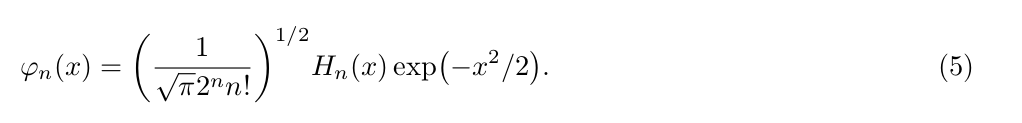

In [177]:
from IPython.display import Image
Image(filename='pics/Chebyshev_hermit_basis.png')

Также учтём зависимость от фазы

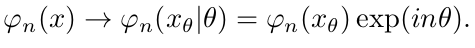

In [178]:
Image(filename='pics/psi_theta.png')

И окончательно получим состояние через найденные пункте 1 коэффициенты $c_n$

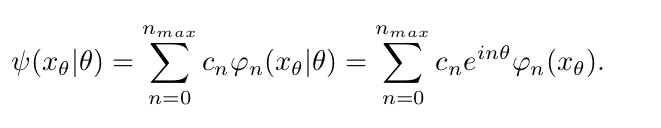

In [179]:
Image(filename='pics/state.png')

In [180]:
def phi_theta(n, x, theta):
    return (1/(np.pi**0.5*2**n*factorial(n)))**(1/2)*hermite(n)(x)*np.exp(-x**2/2)*np.exp(1j*n*theta)

def get_theor_state(cn_list, N, x, theta):
    return np.sum(np.array([cn_list[i]*phi_theta(i, x, theta) for i in range(N)]), axis = 0)
    
def get_probs(state):
    return abs(state)**2

# Более быстрая функция для вероятности. Понадобится при решении УП
def p_(phi_theta, psi):
    return abs(np.tensordot(psi, phi_theta, axes=1))**2

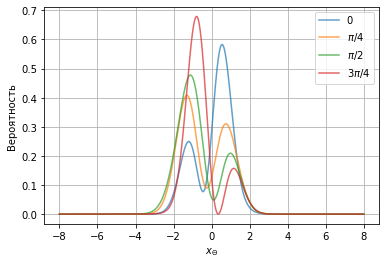

In [181]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

for theta, theta_label in zip(thetas, thetas_label):
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', alpha=0.7, label=theta_label)
plt.xlabel('$x_\Theta$')
plt.ylabel('Вероятность')
plt.legend()
plt.grid()
plt.show()

# Пункт 3:
#### Выполним симуляцию измерений для каждого значения $\theta$

In [182]:
def F(z, x_list, state):
    return np.trapz(get_probs(state)[x_list <= z], x_list[x_list <= z])

In [183]:
n = 10000
L = 10
inv_points = 100



x_list = np.linspace(-L, L, inv_points)

thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

Func_list = []
x_rec_list = []

for theta in thetas:
    y = []
    state = get_theor_state(cn_list, N, x_list, theta)
    for x_inv in tqdm(x_list):
        y.append(F(x_inv, x_list, state))
                 
    # Восстановим функцию распределения
    F_inv = interpolate.interp1d(y, x_list, fill_value=(0, 1), bounds_error=False)
    Func_list.append(F_inv)
    
    # Из восстановленной ф-ии распределения сгенерируем 1000 случайных величин
    # Каждое соответствует измерению
    y_random = np.random.rand(n)
    x_reconstructed = F_inv(y_random)
    x_rec_list.append(x_reconstructed)
    

100%|██████████| 100/100 [00:00<00:00, 10114.80it/s]


#### Построим соответствующие распределения

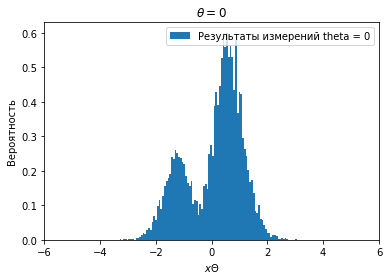

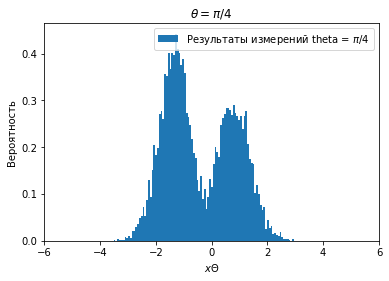

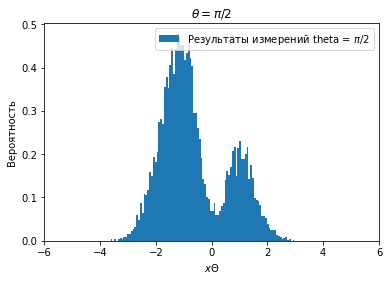

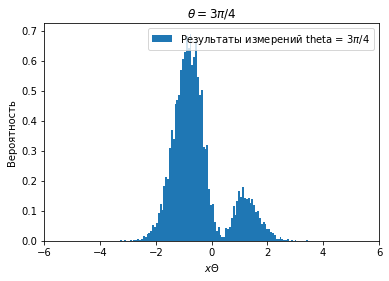

In [184]:
for x_rec, theta_label in zip(x_rec_list, thetas_label):   
    plt.hist(x_rec, bins=100, density=True, label=f'Результаты измерений theta = {theta_label}')
    plt.xlabel('$x \Theta$')
    plt.ylabel('Вероятность')
    plt.title(r'$\theta = $' + f'{theta_label}')
    plt.xlim(-6, 6)
    plt.legend()
    plt.show()

# Пункт 4:

#### Проведём реконструкцию состояния методом MLE

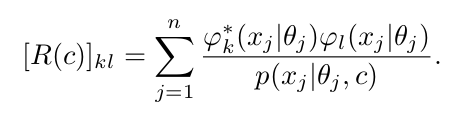

In [185]:
Image(filename='pics/R_matrix.png')

Создадим полный набор $(x_j, \theta_j)$

In [186]:
len(x_rec_list[0])

10000

In [187]:
# Полный набор измерений состоит из 4000 измерений по 4000 на каждую theta
x_rec_list = np.array(x_rec_list)

thetas_list = []
for theta in thetas:
    thetas_list.append([theta]*x_rec_list.shape[1])
    
thetas_list = np.array(thetas_list)


In [188]:
# Зададим функцию собирающую матрицу R(c)

# Заметим, что числители дробей в сумме выше не зависят от c. 
# Посчитаем их заранее, чтобы не пересчитывать на каждой итерации далее


def get_R_numerators(N = 9, thetas = thetas, x_rec_list = x_rec_list):
    psi_n_list = []
    for n in range(N):
        psi = []
        for theta, x in zip(thetas, x_rec_list):       
            psi.append(phi_theta(n, x, theta))
        psi = np.array(psi).flatten()
        psi_n_list.append(psi)
    
    numerators_list = np.reshape([psi1.conj()*psi2 for psi1 in psi_n_list for psi2 in  psi_n_list], (9,9,40000))                       
    return np.array(numerators_list).T

numerators_list = get_R_numerators()

In [189]:
def get_R(c, numerators_list):
    denumerators_list = []
    for theta, x in zip(thetas, x_rec_list):
        state = get_theor_state(c, N, x, theta)
        p = get_probs(state)
        denumerators_list.append(p)
        
    denumerators_list = np.array(denumerators_list).flatten()
    return np.sum(numerators_list/np.reshape(denumerators_list, (40000, 1, 1)), axis = 0).T
    
    

In [190]:
# Проверим работу ф-ии
c = np.random.randn(9)
c = c/np.sqrt(c**2)
R = get_R(c, numerators_list)
print(R)

[[ 28808677.46552015+0.00000000e+00j  24012842.44132614-9.19744950e+03j
   -5919554.54776504-5.15303639e+02j -22537945.22015777+1.07156782e+03j
   -4350789.05625375+2.53682069e-12j  18499905.50711714+4.23156535e+03j
   10290084.80516431+1.60246754e+02j -13788785.96296572+3.97076969e+03j
  -13743884.38082287-8.59726332e-13j]
 [ 24012842.44132614+9.19744950e+03j  20477758.47070506+0.00000000e+00j
   -5076130.31596325-1.12044209e+04j -18909679.0092049 -1.99409198e+02j
   -3708844.14907891-7.31893215e+03j  15493572.7763717 +4.04293197e-12j
    8829674.76566805-1.58332634e+03j -11661375.14061878+5.01103643e+02j
  -11747611.89745827+2.06904191e+03j]
 [ -5919554.54776504+5.15303639e+02j  -5076130.31596325+1.12044209e+04j
    1482900.52663015+0.00000000e+00j   4472371.87780457-1.78205863e+03j
     868566.19818053+7.75835854e+01j  -3652160.82578621-5.83767759e+03j
   -2192902.62184396-6.29494677e-13j   2775300.28796291-5.89731191e+03j
    2921877.39744017-1.20942989e+02j]
 [-22537945.22015777-1

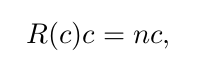

In [191]:
Image(filename='pics/iter_method.png')

In [192]:
%%time

eps = 1e-8
mu=0.5

# Зададим случайное чистое состояние в качестве начального приближения
c = np.random.randn(9)
c = c/np.sqrt(c**2)

for i in tqdm(range(1000)):
    c_prev = c
    c = (1-mu)*get_R(c_prev, numerators_list) @ c_prev/ 40000 + mu*c_prev
    print(np.sum(abs(c_prev - c)**2)**0.5)
    if np.sum(abs(c_prev - c)**2)**0.5 < eps:
        break
    
    


  0%|          | 1/1000 [00:00<02:02,  8.17it/s]

1.3516137610063743


  0%|          | 2/1000 [00:00<01:55,  8.65it/s]

0.6649906947332768


  0%|          | 3/1000 [00:00<01:48,  9.17it/s]

0.3110637524192636


  0%|          | 4/1000 [00:00<01:46,  9.36it/s]

0.1871641124260462


  1%|          | 6/1000 [00:00<01:42,  9.68it/s]

0.15203259656643833
0.12656892851977444
0.10892726811465639


  1%|          | 8/1000 [00:00<01:38, 10.06it/s]

0.10153270560889871
0.13581359537293397


  1%|          | 10/1000 [00:01<01:37, 10.14it/s]

0.12476153222410827
0.09503679125361549


  1%|          | 12/1000 [00:01<01:44,  9.47it/s]

0.07568328220872524


  1%|▏         | 13/1000 [00:01<01:46,  9.28it/s]

0.06301670680584041


  2%|▏         | 15/1000 [00:01<01:41,  9.71it/s]

0.0509315875132063
0.040009954684484775


  2%|▏         | 16/1000 [00:01<01:43,  9.55it/s]

0.031225239673737658


  2%|▏         | 17/1000 [00:01<01:42,  9.56it/s]

0.021459848009250118


  2%|▏         | 19/1000 [00:01<01:39,  9.81it/s]

0.014438025474571084
0.009663924260074891


  2%|▏         | 21/1000 [00:02<01:44,  9.40it/s]

0.006598373100489258
0.004664094679559021
0.0034258547283497064


  2%|▎         | 25/1000 [00:02<01:35, 10.26it/s]

0.0026047201001436963
0.0020789356376607207
0.0018876809030987033


  3%|▎         | 27/1000 [00:02<01:33, 10.40it/s]

0.002186145438040881
0.0032946317275585903


  3%|▎         | 29/1000 [00:03<01:43,  9.35it/s]

0.005002984760233945
0.004813575729611788


  3%|▎         | 32/1000 [00:03<01:38,  9.81it/s]

0.0038529325872986393
0.003159360483550172
0.0026158420411482174


  3%|▎         | 34/1000 [00:03<01:40,  9.66it/s]

0.0021737403535929457
0.0018152504537631313


  4%|▎         | 36/1000 [00:03<01:53,  8.49it/s]

0.0015270590431273473
0.001295633398645653


  4%|▍         | 38/1000 [00:04<01:50,  8.71it/s]

0.0011083012185613224
0.0009546451824217628


  4%|▍         | 40/1000 [00:04<01:45,  9.07it/s]

0.0008268355771082261
0.0007192096331828771


  4%|▍         | 42/1000 [00:04<01:53,  8.44it/s]

0.0006276657378430552
0.0005491679619823968


  4%|▍         | 45/1000 [00:04<01:42,  9.35it/s]

0.00048141235270875876
0.0004226137843016828
0.0003713663869772993


  5%|▍         | 47/1000 [00:04<01:41,  9.42it/s]

0.0003265473269902636
0.00028724764439973374


  5%|▍         | 49/1000 [00:05<01:38,  9.62it/s]

0.00025272145248720035
0.00022234836423720453
0.00019560569325594428


  5%|▌         | 53/1000 [00:05<01:32, 10.21it/s]

0.00017204789854664121
0.00015129135813473884
0.0001330030229152443


  6%|▌         | 55/1000 [00:05<01:30, 10.46it/s]

0.00011689186997053634
0.00010270236318587586
9.020935050741192e-05


  6%|▌         | 59/1000 [00:06<01:28, 10.68it/s]

7.921399302648893e-05
6.954044229682159e-05
6.1033069016659334e-05


  6%|▌         | 61/1000 [00:06<01:29, 10.47it/s]

5.355410709078829e-05
4.698161913094059e-05
4.12077180830275e-05


  6%|▋         | 65/1000 [00:06<01:29, 10.43it/s]

3.6136998940593995e-05
3.1685147362333333e-05
2.7777700547897502e-05


  7%|▋         | 67/1000 [00:06<01:29, 10.38it/s]

2.4348941393477255e-05
2.1340910737278465e-05
1.87025250815356e-05


  7%|▋         | 71/1000 [00:07<01:28, 10.46it/s]

1.6388788981319757e-05
1.4360092605851284e-05
1.2581585988844447e-05


  7%|▋         | 73/1000 [00:07<01:28, 10.49it/s]

1.1022622302966411e-05
9.656263191594976e-06
8.458839807831142e-06


  8%|▊         | 77/1000 [00:07<01:26, 10.69it/s]

7.40956377215787e-06
6.490182778257297e-06
5.684676058066293e-06


  8%|▊         | 79/1000 [00:08<01:26, 10.60it/s]

4.978985366626856e-06
4.360777565307659e-06
3.819235269453791e-06


  8%|▊         | 83/1000 [00:08<01:25, 10.76it/s]

3.3448723851259585e-06
2.9293716885863307e-06
2.565441903791417e-06


  8%|▊         | 85/1000 [00:08<01:26, 10.53it/s]

2.24669200735441e-06
1.9675207396843647e-06
1.723019526006274e-06


  9%|▉         | 89/1000 [00:08<01:23, 10.90it/s]

1.508887213519223e-06
1.321355212783105e-06
1.1571217944169697e-06


  9%|▉         | 91/1000 [00:09<01:25, 10.66it/s]

1.0132944371737683e-06
8.873392534421863e-07
7.770366325987351e-07


 10%|▉         | 95/1000 [00:09<01:23, 10.90it/s]

6.80442345546721e-07
5.958534435177694e-07
5.217783648896722e-07


 10%|▉         | 97/1000 [00:09<01:21, 11.02it/s]

4.569107339817883e-07
4.001063986913494e-07
3.503633084408039e-07


 10%|█         | 101/1000 [00:10<01:21, 11.08it/s]

3.068038829388543e-07
2.6865956436344387e-07
2.3525728377090276e-07


 10%|█         | 103/1000 [00:10<01:21, 10.95it/s]

2.060076049195248e-07
1.8039433868270893e-07
1.5796544536560872e-07


 11%|█         | 107/1000 [00:10<01:20, 11.03it/s]

1.3832506624321952e-07
1.21126543852399e-07
1.0606630897350748e-07


 11%|█         | 109/1000 [00:10<01:21, 10.90it/s]

9.287852642660634e-08
8.133040603507712e-08
7.121809579144768e-08


 11%|█▏        | 113/1000 [00:11<01:23, 10.69it/s]

6.236308531354438e-08
5.46090560739647e-08
4.781912305263613e-08


 12%|█▏        | 115/1000 [00:11<01:22, 10.74it/s]

4.18734190414527e-08
3.666697921780315e-08
3.210788865170028e-08


 12%|█▏        | 119/1000 [00:11<01:20, 10.93it/s]

2.8115659950274947e-08
2.4619812685368925e-08
2.155862924600822e-08


 12%|█▏        | 121/1000 [00:11<01:20, 10.88it/s]

1.8878065494402523e-08
1.6530796697388363e-08
1.4475382183104606e-08


 12%|█▏        | 124/1000 [00:12<01:26, 10.09it/s]

1.2675533771188999e-08
1.1099475109545644e-08
9.719380811750765e-09
CPU times: user 11.5 s, sys: 855 ms, total: 12.4 s
Wall time: 12.3 s


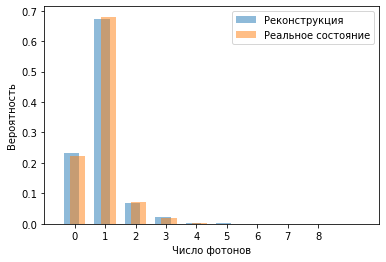

In [193]:
n_list = np.arange(9)

plt.bar(n_list-0.1, abs(c)**2, alpha=0.5, width=0.5, label='Реконструкция')
plt.bar(n_list+0.1, abs(cn_list)**2, alpha=0.5, width=0.5, label='Реальное состояние')
plt.xticks(n_list)
plt.xlim(-1, 10)
plt.xlabel('Число фотонов')
plt.ylabel('Вероятность')
plt.legend()
plt.show()

In [194]:
# Рассчитаем Fidelity между реконструкцией и реальным состоянием
Fidelity_pure(c, cn_list)

0.9994586162756013

Состояния совпадаяют с высокой точностью

# Пункт 4:

#### Построим распределения для различных $\theta$

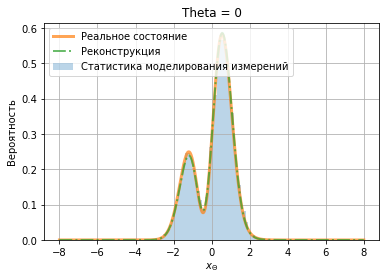

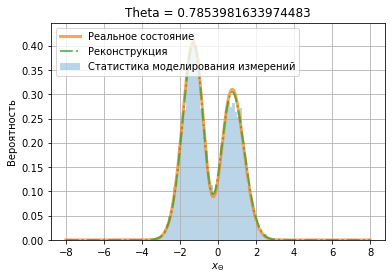

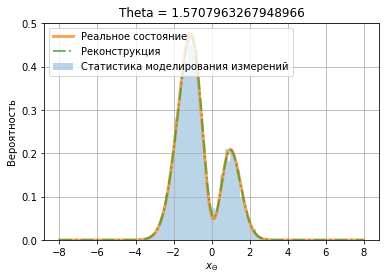

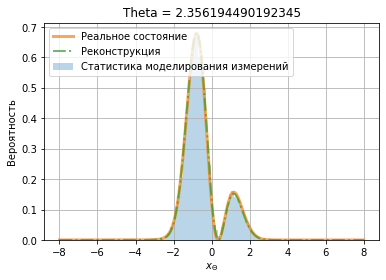

In [195]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']


for x, theta, theta_label in zip(x_rec_list, thetas, thetas_label):
    
    plt.hist(x, density = True, bins = 50, alpha = 0.3, label = 'Статистика моделирования измерений')
    
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', linewidth = 3, alpha=0.7, label='Реальное состояние')
    
    p_list = get_probs(get_theor_state(c, N, x_list, theta))
    plt.plot(x_list, p_list, '-.', linewidth = 2, alpha=0.7, label='Реконструкция')
    
    plt.title(f'Theta = {theta}')
    plt.xlabel('$x_\Theta$')
    plt.ylabel('Вероятность')
    plt.legend(loc='upper left')
    plt.grid()
    
    plt.show()
    
    

# Пункт 6:

#### Вычислим p-value для всех $\theta$

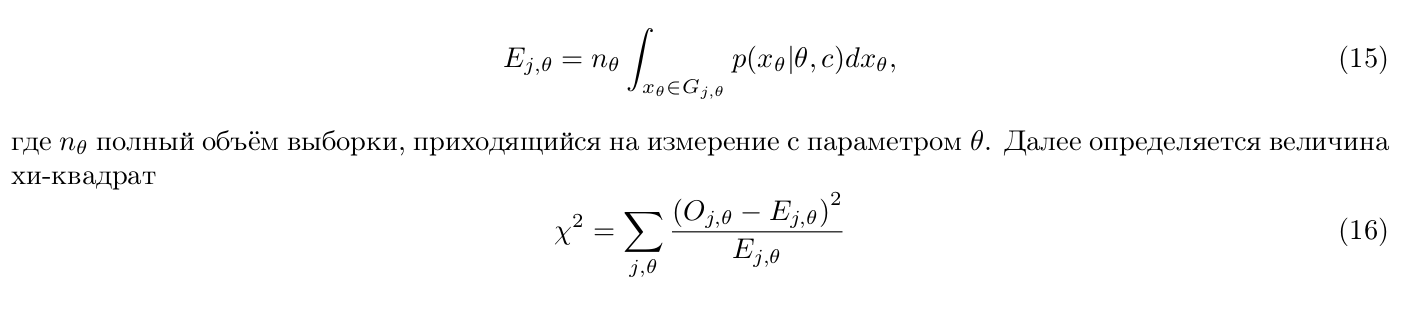

In [196]:
Image(filename='pics/Chi2.png')

In [197]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000



E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x = np.array(sorted(x))
#     x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x_bins = np.linspace(x.min(), x.max(), n_bins+1)
#     x_bins[0] -= 1
    x_bin_prev = x_bins[0]
#     x_bins[-1] += 1
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>x_bin_prev)]
        O = len(x_vals)
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

In [198]:
print(f'nt = {nt}')
print(f'sum(E_list) для соответствующих theta = {np.sum(np.reshape(E_list, (4, n_bins)), axis = 1)}')

nt = 10000
sum(E_list) для соответствующих theta = [9977.02688953 9972.51386195 9976.38697017 9981.95634046]


In [199]:
nu = 4*n_bins - len(thetas) - 2*(N - 1) + 1
p_value = 1 - chi2.cdf(np.abs(Xi2), nu)
print('p-value = ' + str(p_value))

p-value = 1.1885588668825164e-07


Для визуализации разобьём на меньшее количество бинов (n_bins = 10)

In [200]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000

E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x = np.array(sorted(x))
#     x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x_bins = np.linspace(x.min(), x.max(), n_bins+1)
#     x_bins[0] -= 1
    x_bin_prev = x.min()
#     x_bins[-1] += 1
    
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>x_bin_prev)]
        O = len(x_vals)
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

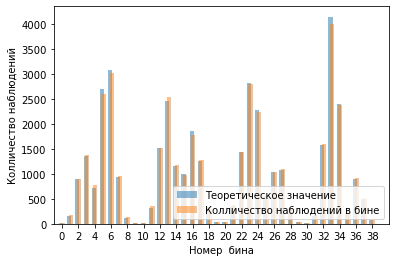

In [201]:
n_list = np.arange(E_list.shape[0])

plt.bar(n_list-0.1, E_list, alpha=0.5, width=0.5, label='Теоретическое значение')
plt.bar(n_list+0.1, O_list, alpha=0.5, width=0.5, label='Колличество наблюдений в бине')
plt.xticks(n_list[0::2])
plt.xlim(-1, E_list.shape[0])
plt.xlabel('Номер  бина')
plt.ylabel('Колличество наблюдений')
plt.legend(loc = 'lower right')
plt.show()

In [202]:
x_bins

array([-3.2725732 , -2.60115484, -1.92973649, -1.25831814, -0.58689979,
        0.08451857,  0.75593692,  1.42735527,  2.09877362,  2.77019197,
        3.44161033])